***read the data***

In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
os.getcwd()

'C:\\Users\\Araz\\Desktop\\New folder'

In [56]:
df = pd.read_csv(os.getcwd()+'\\RSCCASN.csv',index_col='DATE',parse_dates=True)
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


***see the data***

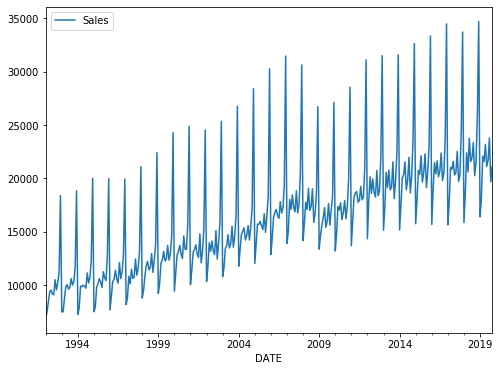

In [57]:
df.plot(figsize=(8,6))


**preprocessing**

In [58]:
test_size = 18
test_ind = len(df) - test_size

In [59]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

**train generator**

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 12
no_features = 1 # number of features
generator = TimeseriesGenerator(data=scaled_train,
                                targets=scaled_train,
                                length=length,
                                batch_size=1) # bath_size usually 1 is good, if it was 2, for every 2 sets of x&y we would make a change in weights


In [62]:
# visualizing the first batch to see what the data will be trained on
x,y = generator[0]
print(x)
print(y)

[[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]
[[0.02047633]]


## Model

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [64]:
model = Sequential()
model.add(LSTM(100, activation='relu', dropout=0.1, input_shape=(length,no_features)))
model.add(Dense(1))
model.compile(optimizer='Adam' ,loss='mse') # mse because the data is continues (mean square error)

***early stopping***

In [65]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

***validation generator***

In [66]:
validation_generator = TimeseriesGenerator(data=scaled_test,
                                           targets=scaled_test,
                                           length=length,
                                           batch_size=1)

## train

In [67]:
model.fit_generator(generator,
                    epochs=5,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/5
304/304 [==============================] - 14s 45ms/step - loss: 0.0312 - val_loss: 0.0388
Epoch 2/5
304/304 [==============================] - 14s 46ms/step - loss: 0.0217 - val_loss: 0.0054
Epoch 3/5
304/304 [==============================] - 13s 43ms/step - loss: 0.0146 - val_loss: 0.0041
Epoch 4/5
304/304 [==============================] - 11s 37ms/step - loss: 0.0110 - val_loss: 7.7129e-04
Epoch 5/5
304/304 [==============================] - 11s 37ms/step - loss: 0.0078 - val_loss: 0.0055


***visualize losses***

In [68]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.031171,0.038756
1,0.021685,0.005361
2,0.014578,0.004051
3,0.011000,0.000771
4,0.007809,0.005451


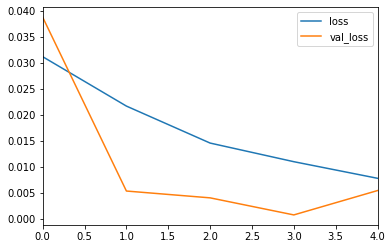

In [69]:
losses.plot()

In [73]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, no_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

C:\Users\Araz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


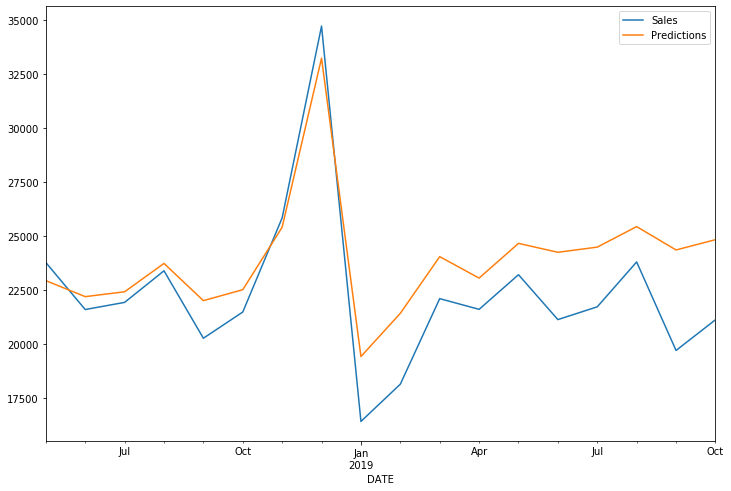

In [75]:
unscaled_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = unscaled_predictions # error not important
test.plot(figsize=(12,8))

### Retrain and Forecasting

In [86]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [87]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, no_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 14s 43ms/step - loss: 0.0244
Epoch 2/8
322/322 [==============================] - 15s 48ms/step - loss: 0.0185
Epoch 3/8
322/322 [==============================] - 16s 49ms/step - loss: 0.0130
Epoch 4/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0054
Epoch 5/8
322/322 [==============================] - 13s 40ms/step - loss: 0.0024
Epoch 6/8
322/322 [==============================] - 12s 38ms/step - loss: 0.0021
Epoch 7/8
322/322 [==============================] - 11s 34ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 11s 34ms/step - loss: 0.0013


In [94]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, no_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [95]:
forecast = scaler.inverse_transform(forecast)
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [96]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS') # 'freq' you chose based on the date type which here is month start frequency, see documentation
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])
forecast_df

,Forecast
2019-11-01,26698.734189
2019-12-01,37349.885007
2020-01-01,17195.029770
2020-02-01,19248.187143
2020-03-01,22648.414621
2020-04-01,22311.507751
2020-05-01,23859.326983
2020-06-01,22026.266765
2020-07-01,22668.095924
2020-08-01,24544.192986


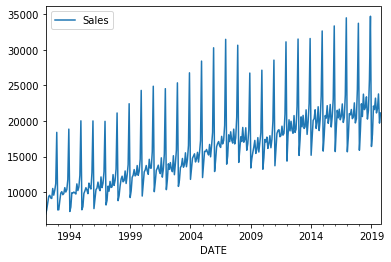

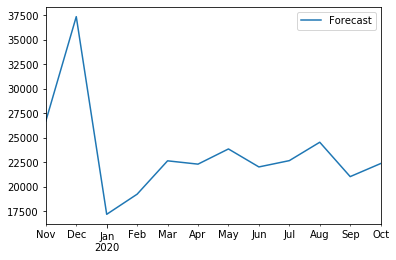

In [97]:
df.plot()
forecast_df.plot()

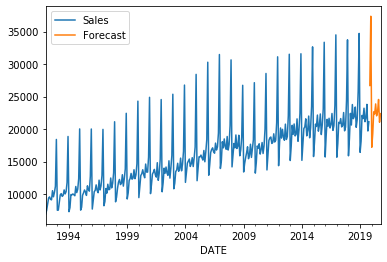

In [98]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

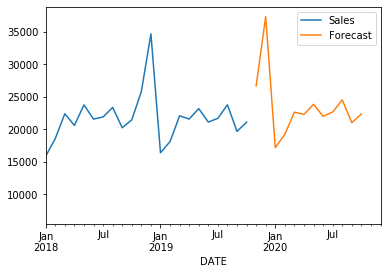

In [99]:
# zoomed a bit
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')